In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

In [2]:
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
Tickers = df['Symbol'].to_numpy().tolist()

In [3]:
#df =  yf.download(tickers=Tickers, period='1y') # Download Data from Yahoo Finance
df =  yf.download(tickers=Tickers, start="2020-01-01", end="2020-12-31")


[*********************100%***********************]  505 of 505 completed


In [4]:
# Take the Adjusted Returns from the data for the companies that are in the list for at least 10 years
df=df['Adj Close']
df

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,84.623528,28.574404,158.652695,72.783936,83.895599,83.531898,170.589996,85.511848,207.243088,329.809998,...,96.293915,64.619324,56.056503,34.930084,77.761459,98.828346,148.496262,255.440002,50.029121,131.596085
2020-01-02,85.258377,28.982893,157.909729,74.444603,84.852608,83.590858,168.809998,85.600449,206.829712,334.429993,...,100.115349,65.656494,56.393299,34.986931,78.807625,100.241150,148.020065,259.140015,50.530182,133.375900
2020-01-03,83.889473,27.548195,157.919632,73.720840,84.047203,82.539597,166.820007,84.556908,206.485229,331.809998,...,97.810677,65.128654,55.769238,34.532185,79.271484,99.927193,147.633148,256.049988,49.817135,133.395782
2020-01-06,84.137466,27.219410,155.324310,74.308266,84.710480,83.748055,179.039993,84.999916,205.136902,333.709991,...,95.771927,65.628716,56.076317,34.011127,78.758286,99.868332,146.779953,258.010010,49.210079,132.371658
2020-01-07,84.395378,27.119778,153.481827,73.958794,84.227234,83.148727,180.350006,84.527367,200.707962,333.390015,...,97.958405,65.091606,56.373489,34.058491,78.462196,100.044937,146.650970,256.470001,48.911369,132.819077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,117.107948,15.890000,159.289993,130.960007,103.279999,97.239998,304.049988,107.449997,257.440002,496.910004,...,141.990005,41.770000,51.610001,22.531420,99.730003,106.790001,148.740005,379.739990,43.509998,159.850006
2020-12-24,117.117928,15.660000,160.679993,131.970001,103.260002,96.970001,303.410004,108.349998,257.299988,499.859985,...,141.990005,41.599998,51.820000,22.333601,100.250000,107.540001,149.250000,376.890015,43.340000,160.720001
2020-12-28,117.637077,16.059999,158.800003,136.690002,103.449997,96.800003,312.910004,107.790001,259.679993,498.950012,...,141.520004,41.740002,52.310001,23.025963,100.370003,109.779999,148.889999,382.589996,43.360001,162.389999


In [5]:
df1 = df[1:]
df0 = df[:-1]
pt1 = df1.reset_index(drop=True)
pt0 = df0.reset_index(drop=True)
ret = (pt1-pt0)/pt0
ret.index = df1.index

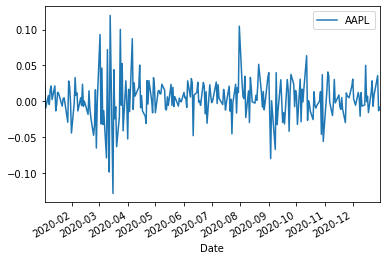

In [6]:
ret.plot(y='AAPL', kind = 'line')
plt.show()

In [7]:
lst=[]
for col in df.columns:
    if df[col].isna().sum() > 0:
        lst.append(col)
ret.drop(columns=lst,inplace=True)

### Grid Search for Parameters of ARIMA(p,d,q)

In [8]:
def evaluate_arima_model(X, arima_order):
    X = X.astype('float32')
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(trend='c', disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
  # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for q in q_values:
            order = (p,d_values,q)
            try:
                rmse = evaluate_arima_model(dataset, order)
                if rmse < best_score:
                    best_score, best_param = rmse, order
            except:
                continue
    return best_param

In [9]:
def prediction_arima_model(X, arima_order):
    X = X.astype('float32')
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(trend='c', disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    return predictions

In [10]:
train_size = int(len(ret) * 0.75)
train_ret, test_ret = ret[0:train_size], ret[train_size:]
clmn = list(ret)
orders_df = pd.DataFrame(columns=clmn)
predictions_df = pd.DataFrame(columns=clmn)
p_values = range(1,4)
q_values = range(0,3)
for i in clmn:
    warnings.filterwarnings("ignore")
    orders_df[i] = evaluate_models(train_ret[i], p_values, 0, q_values)
    arima_orders = (orders_df[i][0],orders_df[i][1],orders_df[i][2])
    try:
        predictions_df[i] = prediction_arima_model(ret[i],arima_orders)
    except:
        continue

In [12]:
predictions_df.to_csv('prediction_arima.csv')

In [13]:
predictions_df.index = test_ret.index

In [15]:
predictions_df.to_csv('prediction_arima_withdate.csv')